In [1]:
import numpy as np
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, interpline, CoordPair)

wrf_file = Dataset("wrfout_d01_2017-01-08_02:45:00")
ncfile = Dataset("wrfout_d01_2017-01-08_02:45:00")

# Define the cross section start and end points
start_point = CoordPair(lat=44.210682, lon=-115.40195)
end_point = CoordPair(lat=44.206, lon=-115.449066)

z = getvar(wrf_file, "z", timeidx=-1)
ht = z
ter = getvar(wrf_file, "ter", timeidx=-1)
cloud_mix = ncfile['QCLOUD'][:].squeeze()*1000 #G/KG
ice_mix = ncfile['QICE'][:].squeeze()*1000 #G/KG
rain_mix = (ncfile['QRAIN'][:].squeeze() + ncfile['QSNOW'][:].squeeze() + ncfile['QGRAUP'][:].squeeze())*1000

In [2]:
tntr = -16
tint = 2
tmin = -36
tmax = -0
cntr = .45
cint = .01
cmin = .05
cmax = .90
iint = 0.005
imin = 0.001
imax = 0.3

Lmin = 5
Lmax = 72
Lint = 1
levs = np.arange(Lmin,Lmax,Lint)

clevs = np.arange(cmin, cmax, cint)
tevs = np.arange(tmin, tmax, tint)
ievs = np.arange(imin, imax, iint)
cloud_cross = vertcross(cloud_mix, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)
ice_cross = vertcross(ice_mix, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)
rain_cross = vertcross(rain_mix, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)
ter_line = interpline(ter, wrfin=wrf_file, start_point=start_point,
                      end_point=end_point)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/wrf_python-1.3.2-py3.7-linux-x86_64.egg/wrf/metadecorators.py:1109: UserWarning: 'latlon' is set to True, but 'field3d' is not of type xarray.DataArray and contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' is "


In [3]:
#All of this is to get the ys

dbz = getvar(wrf_file, "dbz", timeidx=-1)
max_dbz = getvar(wrf_file, "mdbz", timeidx=-1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
z_cross = vertcross(Z, ht, wrfin=wrf_file,
                    start_point=start_point,
                    end_point=end_point,
                    latlon=True, meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * np.log10(z_cross)

# Add back the attributes that xarray dropped from the operations above
dbz_cross.attrs.update(z_cross.attrs)
dbz_cross.attrs["description"] = "radar reflectivity cross section"
dbz_cross.attrs["units"] = "dBZ"

# To remove the slight gap between the dbz contours and terrain due to the
# contouring of gridded data, a new vertical grid spacing, and model grid
# staggering, fill in the lower grid cells with the first non-missing value
# for each column.

# Make a copy of the z cross data. Let's use regular numpy arrays for this.
dbz_cross_filled = np.ma.copy(to_np(dbz_cross))

# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(dbz_cross_filled.shape[-1]):
    column_vals = dbz_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. Since 0 is a valid value
    # for dBZ, let's change that threshold to be -200 dBZ instead.
    first_idx = int(np.transpose((column_vals > -200).nonzero())[0])
    dbz_cross_filled[0:first_idx, i] = dbz_cross_filled[first_idx, i]


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


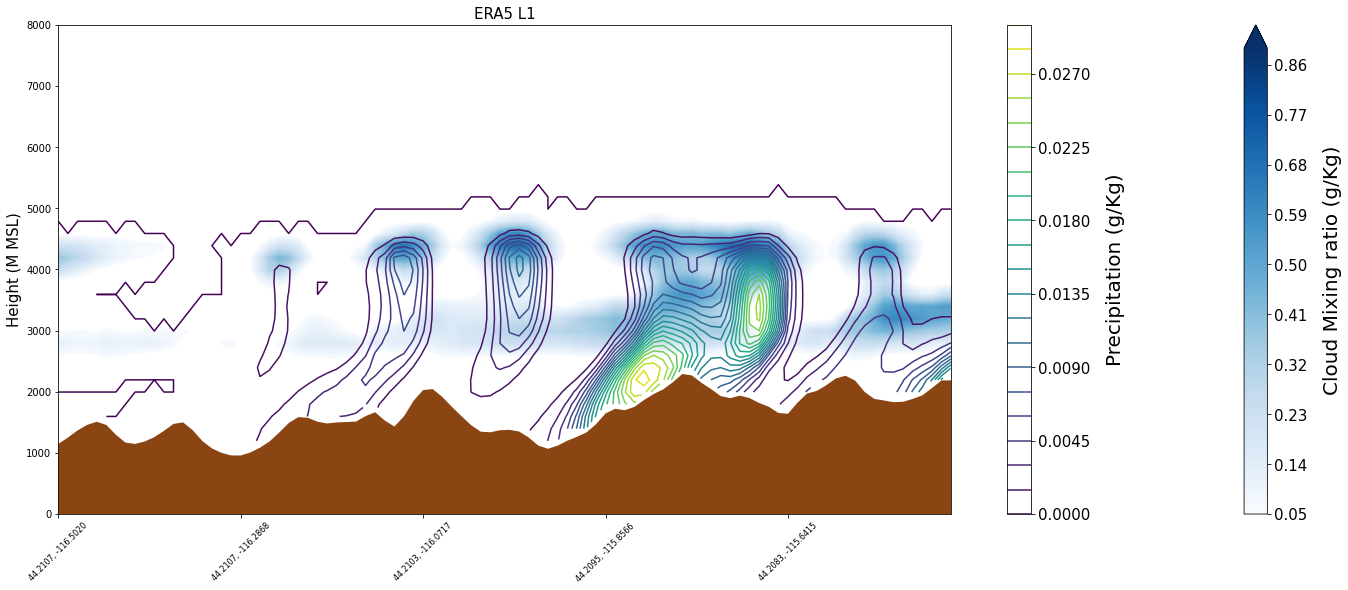

In [6]:
# Get the lat/lon points
lats, lons = latlon_coords(z)

# Get the cartopy projection object
cart_proj = get_cartopy(z)

# Create the figure
fig = pyplot.figure(figsize=(8,6))
ax_cross = pyplot.axes()

xs = np.arange(0, cloud_cross.shape[-1], 1)
ys = to_np(dbz_cross.coords["vertical"])
cloud_contours = ax_cross.contourf(xs,ys,to_np(cloud_cross),
                                 levels=clevs,
                                 cmap="Blues",
                                 extend="max")

#ice_contours = ax_cross.contour(xs, ys, to_np(ice_cross),10, cmap = get_cmap("cool")) #cmap = get_cmap("RdPu"))
rain_contours = ax_cross.contour(xs, ys, to_np(rain_cross), 20)

ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line),
                                facecolor="saddlebrown")

cbr1=pyplot.colorbar(cloud_contours, ax=ax_cross,pad = 0.05)#, fraction = 0.4)
cbr1.set_label('Cloud Mixing ratio (g/Kg)', fontsize = 20, labelpad = 15)
cbr4=pyplot.colorbar(rain_contours, ax=ax_cross)
cbr4.set_label('Precipitation (g/Kg)', fontsize = 20, labelpad = 15)
#cbr2=pyplot.colorbar(ice_contours, ax=ax_cross)
#cbr2.set_label('Cloud Ice (g/Kg)', fontsize = 20, labelpad = 15)


tick_font_size = 15
cbr1.ax.tick_params(labelsize=tick_font_size)
cbr4.ax.tick_params(labelsize=tick_font_size)
#cbr2.ax.tick_params(labelsize=tick_font_size)
# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
pyplot.ylim(0,8000)

# Set the desired number of x ticks below
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(x_labels[::thin], rotation=45, fontsize=8)
fig.set_size_inches(25, 9)
pyplot.ylabel("Height (M MSL)", fontsize = 15)

pyplot.title("ERA5 L1",fontsize = 15)
pyplot.savefig("NARRL1.png")